<a href="https://colab.research.google.com/github/Mehmet-Bsg/various-projects/blob/main/segmentation_practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation

In this notebook we will train and test a deep learning model to perform binray image segmentation. 

This notebook deals with Whole Slide Images (WSI). Whole slide imaging, also known as virtual microscopy, refers to scanning a complete microscope slide and creating a single high-resolution digital file. 

In [1]:
import os
import json
from datetime import datetime
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.keras import backend as K
import imageio
import numpy as np
from scipy import ndimage
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/MyDrive/Data'

/content/gdrive/MyDrive/Data


# Fetching data

First step is to implement functions to send data to the training and testing pipeline. To do so, we implement the class DataGeneratorTissue used to select patches of images by customising keras DataGenerator class.  

The function *get_random_patch_coord* randomly selects the coordinates of an image's patch, or crop. A *patch_coord* points to the top left corner of the corresponding patch. Thus the coordinates [y, x] gives for a patch of size [h, w] the image's patch *image* [y:y+h, x:x+w].

The function *choose_patch_coord* calls *get_random_patch_coord* and should return the coordinates of a patch with at most 70% of background labels (pixel value of 0 in label). If it cannot be achieved after 10 tryouts, the function should return the coordinates of the patch with the lowest background labels found.  

In [3]:
class DataGeneratorTissue(keras.utils.Sequence):
    
    def __init__(self, path, prefix, batch_size, 
                 patch_size, nb_channels_in=3, nb_channels_out=1,
                 geometric_augmentations=[], augmentation_ratio=None):
        
        self.path = path
        self.prefix = prefix
        self.get_data_dict()
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.nb_channels_in = nb_channels_in
        self.nb_channels_out = nb_channels_out
        self.geometric_augmentations = []
        self.augmentation_ratio = augmentation_ratio
        
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, batch_idx):
        batch_data_idxs = self.data_idxs[batch_idx*self.batch_size:(batch_idx+1)*self.batch_size]
        x, y = self.fetch_data(batch_data_idxs)
        return x, y

    def on_epoch_end(self):
        self.data_idxs = np.arange(len(self.data))
        np.random.shuffle(self.data_idxs)
    
    def get_data_dict(self):
        self.data = {}
        for data_idx, image_name in enumerate(os.listdir(os.path.join(*[self.path, self.prefix, "jpg"]))):
            self.data[data_idx] = image_name
    
    def get_random_patch_coord(self, image_size):
        '''
        image_size: (height, width)
        '''
        
        
        inf_coord = [0,0]
        sup_coord = [image_size[0]-self.patch_size[0], image_size[1]-self.patch_size[1]]
        patch_coord = np.random.randint(inf_coord, sup_coord)

        ####  
        
        return patch_coord 
    
    def choose_patch_coord(self, image_shape, label, threshold=0.7):
        '''
        image_shape: (height, width)
        label: shape (height, width, channels)
        '''
        best_patch_coord = None
        lowest_bg_per = np.inf
        

        for _ in range(10):
            patch_coord = self.get_random_patch_coord(image_shape)
            label_patch = label[patch_coord[0] : patch_coord[0] + self.patch_size[0], patch_coord[1] : patch_coord[1] + self.patch_size[1],0]
            nb_pixels_b = np.sum(np.where(label_patch[...,0] == 0,1,0))
            b_per = nb_pixels_b / (label_patch.shape[0] * label_patch.shape[1])
            
            if b_per < threshold : 
              return patch_coord

            if b_per < lowest_bg_per:
              best_patch_coord = patch_coord
              lowest_bg_per = b_per
        
            
        return best_patch_coord
         
        
    def fetch_data(self, batch_data_idxs):
        x = np.empty([self.batch_size, *self.patch_size, self.nb_channels_in])
        y = np.empty([self.batch_size, *self.patch_size, self.nb_channels_out])
        
        for idx, data_idx in enumerate(batch_data_idxs):
            image_file_path = os.path.join(*[self.path, self.prefix, "jpg", self.data[data_idx]])
            image = imageio.imread(image_file_path)
            
            label_file_path = os.path.join(*[self.path, self.prefix, "lbl", self.data[data_idx]])
            label = imageio.imread(label_file_path)
            
            image = np.float32(image/255)
            label = np.expand_dims(np.float32(label/255), axis=-1)
            
            patch_coord = self.choose_patch_coord(list(image.shape[:2]), label)
            
            image_patch = image[patch_coord[0]:patch_coord[0]+self.patch_size[0], 
                                patch_coord[1]:patch_coord[1]+self.patch_size[1],:]
            label_patch = label[patch_coord[0]:patch_coord[0]+self.patch_size[0], 
                                patch_coord[1]:patch_coord[1]+self.patch_size[1],:]
            
            if len(self.geometric_augmentations) != 0:
                if np.random.binomial(1, self.augmentation_ratio) == 1:
                    augm_idx = random.randint(0,len(self.geometric_augmentations)-1)
                    image_patch, label_patch = self.geometric_augmentations[augm_idx](image_patch, label_patch)
                              
            x[idx:idx+1,...] = image_patch
            y[idx:idx+1,...] = label_patch
            
        return x, y

# U-Net model builder

The deep learning model we will use is a U-Net model.

We implement the encoder and decoder parts of the U-Net model with skip connections in the *build_unet_model* function using only *conv_block*, *up_sampler* and *keras.layers.Concatenate()* functions.

In [4]:
def conv_block(filters, strides, last_activation=None):
    if last_activation == None:
        conv_block = keras.Sequential([keras.layers.Conv2D(filters=filters, kernel_size=3, 
                                                           strides=1, padding="same", 
                                                           kernel_initializer = "he_normal"),
                                       keras.layers.BatchNormalization(),
                                       keras.layers.LeakyReLU(), 
                                       keras.layers.Conv2D(filters=filters, kernel_size=3, 
                                                           strides=strides, padding="same", 
                                                           kernel_initializer = "he_normal"), 
                                       keras.layers.BatchNormalization(), 
                                       keras.layers.LeakyReLU()])
    else:
        conv_block = keras.Sequential([keras.layers.Conv2D(filters=filters, kernel_size=3, 
                                                           strides=strides, padding="same", 
                                                           kernel_initializer = "he_normal"),
                                       keras.layers.BatchNormalization(),
                                       keras.layers.Activation(last_activation)])
    return conv_block

def up_sampler(filters):
    up_sampler = keras.Sequential([keras.layers.Conv2DTranspose(filters=filters, kernel_size=2, 
                                                                strides=2, padding="valid", 
                                                                kernel_initializer = "he_normal"), 
                                   keras.layers.BatchNormalization(), 
                                   keras.layers.LeakyReLU()])
    return up_sampler
    
def build_unet_model(nb_channels_in, nb_channels_out, 
                     unet_filters, last_activation, 
                     image_size=[None, None]):
    inputs = keras.Input([*image_size, nb_channels_in])
    
    skip = []

    
    # Encoder part
    import copy 
    inp = inputs 

    for j in range (len(unet_filters)):
      inp = conv_block(filters = unet_filters[j], strides = 1, last_activation = last_activation)(inp)
      if j != len(unet_filters) -1 :
        skip.insert(0,(inp))
        inp = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(inp)
  
    # Decoder part
    for x,y in enumerate(range(len(unet_filters)-2, -1, -1)):
      inp = up_sampler(filters = unet_filters[y])(inp)
      inp = keras.layers.concatenate([skip[x],inp], axis = -1)
      inp = conv_block(filters = unet_filters[y], strides = 1, last_activation = last_activation)(inp)
    


    
    outputs = conv_block(nb_channels_out, 1, last_activation)(inp)

    unet_model = keras.Model(inputs, outputs)
    return unet_model

# Segmentation loss

The loss used here is the Jaccard loss, also known as Intersection over Union. As we are working with binary images as outputs, we want to maximize the overlap area of ground truth and predicted masks.

We implement the computation of the cardinal of the intersection and the union between *y_true* and *y_pred*, stored in the variables *intersection* and *union* for the jaccard index-based loss. The function *K.sum()* should be sufficient to do so.

In [5]:
def jaccard_loss(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(K.abs(y_true * y_pred), axis = -1)
    union = K.sum(K.abs(y_true) + K.abs(y_pred), axis = -1) - intersection


    
    return 1 - (intersection + smooth) / (union + smooth)

# Data augmentation


In [6]:
def flip_aug(image, label):
    flipped_image = np.flip(image, axis=1)
    flipped_label = np.flip(label, axis=1)
    return flipped_image, flipped_label

def rot_aug(image, label):
    image_rotation = ndimage.rotate(image, angle=random.randint(low=-20, high=20))
    label_rotation = ndimage.rotate(label, angle=random.randint(low=-20, high=20))
    return image_rotation, label_rotation

# Model's training

In [7]:
path = "./tissue"

models_dir = "models"
if os.path.exists(models_dir) == False:
    os.mkdir(models_dir)

model_id = 1

dt = datetime.now()
timestamp = str(dt.hour) + ':' + str(dt.minute) + ':' + str(dt.second) + '-' + str(dt.day) + ':' + str(dt.month) + ':' + str(dt.year)
model_name = "modelID=" + str(model_id) +  "_timestamp=" + timestamp

model_dir = os.path.join(models_dir, model_name)
if os.path.exists(model_dir) == False:
    os.mkdir(model_dir)

nb_channels_in = 3
nb_channels_out = 1
last_activation = "sigmoid"
unet_filters = [8, 16, 32, 64]
patch_size = [128, 128]
batch_size = 5
lr = 0.0001
nb_epochs = 20

model_parameters = {"nb_channels_in": nb_channels_in,
                    "nb_channels_out": nb_channels_out,
                    "last_activation": last_activation,
                    "unet_filters": unet_filters,
                    "patch_size": patch_size,
                    "batch_size": batch_size,
                    "lr": lr,
                    "nb_epochs": nb_epochs}

json.dump(model_parameters, open(os.path.join(model_dir, "model_parameters.json"), "w"))

model = build_unet_model(3, 1, unet_filters, "sigmoid", image_size = patch_size)
model.summary()

train_datagen = DataGeneratorTissue(path, "train", batch_size, 
                                    patch_size, 3, 1,
                                    geometric_augmentations=[flip_aug, rot_aug], augmentation_ratio=0.2)

val_datagen = DataGeneratorTissue(path, "val", batch_size, 
                                  patch_size, 3, 1)

opt = keras.optimizers.Adam(lr)
model.compile(optimizer=opt, loss=jaccard_loss)

model_log_file_path = os.path.join(model_dir, "log.csv")
best_model_weights_file_path = os.path.join(model_dir, "best_model_weights.h5")

callbacks = [
    keras.callbacks.CSVLogger(model_log_file_path),
    keras.callbacks.ModelCheckpoint(best_model_weights_file_path, 
                                    save_best_only=True, save_weights_only=True)]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 8)  256         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 8)    0           ['sequential[0][0]']             
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 16)   1232        ['max_pooling2d[0][0]']      

In [8]:
model.fit(train_datagen, 
          epochs=nb_epochs,
          validation_data=val_datagen, 
          verbose=1,
          callbacks=callbacks)

Epoch 1/20
20/20 [==============================] - 138s 7s/step - loss: 0.3168 - val_loss: 0.3311
Epoch 2/20
20/20 [==============================] - 14s 735ms/step - loss: 0.3076 - val_loss: 0.3254
Epoch 3/20
20/20 [==============================] - 10s 496ms/step - loss: 0.2991 - val_loss: 0.3186
Epoch 4/20
20/20 [==============================] - 8s 380ms/step - loss: 0.2951 - val_loss: 0.3146
Epoch 5/20
20/20 [==============================] - 10s 482ms/step - loss: 0.2895 - val_loss: 0.3102
Epoch 6/20
20/20 [==============================] - 10s 513ms/step - loss: 0.2823 - val_loss: 0.3051
Epoch 7/20
20/20 [==============================] - 7s 373ms/step - loss: 0.2712 - val_loss: 0.3019
Epoch 8/20
20/20 [==============================] - 11s 519ms/step - loss: 0.2692 - val_loss: 0.2953
Epoch 9/20
20/20 [==============================] - 10s 511ms/step - loss: 0.2689 - val_loss: 0.2869
Epoch 10/20
20/20 [==============================] - 10s 518ms/step - loss: 0.2688 - val_loss: 

# Training and Validation loss

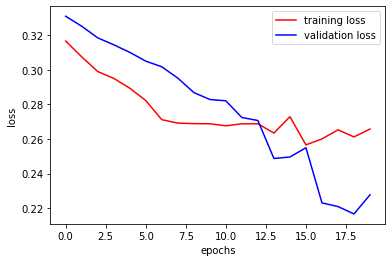

In [9]:
df = pd.read_csv(model_log_file_path, sep=",")
plt.plot(df["epoch"], df["loss"], "r", label="training loss")
plt.plot(df["epoch"], df["val_loss"], "b", label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

### Some remarks : 

It seems like the traning and validation loss are not really similar. What is curious is that the loss don't follow the same varations. i was expecting two decreasing functions. It's either an error in my code or a curious distribution in the data between the training and validation set.

# Model's inference function

*make_apply_unet_model* is the function to call to embeds a U-Net model into a function in charge of the whole pipeline to get from an 8-bit image an 8-bit binary segmentation mask.  
We implement the *apply_unet_model* function.
The pipeline include:  
* a [0,1]-normalization  
* a padding of the image (so that its dimension are 2^{unet_depth = len(unet_filters)-1} divisible)  
* the application of the UNet model  
* an unpadding of the UNet model's output (to retrieve the initial image dimensions)  
* the conversion of the UNet model's output into a binary segmentation mask by taking the label with the highest probability for each pixel  



In [10]:
def pad_image(image, unet_depth):
    shape = image.shape[:2]  
    if shape[0]%2**unet_depth != 0 or shape[1]%2**unet_depth != 0:
        new_shape = [shape[0] + 2**unet_depth - shape[0]%2**unet_depth, 
                     shape[1] + 2**unet_depth - shape[1]%2**unet_depth]
        new_image = np.empty([*new_shape, 3])
        new_image[0:shape[0], 0:shape[1], :] = image[...]
        
        new_image[0:shape[0],shape[1]:new_shape[1],:] = image[:,shape[1]-(new_shape[1]-shape[1]):shape[1],:]
        new_image[shape[0]:new_shape[0],0:shape[1],:] = image[shape[0]-(new_shape[0]-shape[0]):shape[0],:,:]
        new_image[shape[0]:new_shape[0],shape[1]:new_shape[1],:] = image[shape[0]-(new_shape[0]-shape[0]):shape[0],shape[1]-(new_shape[1]-shape[1]):shape[1],:]
        
        return new_image
    else:
        return image
    
def unpad_image(image, old_shape):
    im_shape = image.shape[:2]
    if im_shape[0] == old_shape[0] and im_shape[1] == old_shape[1]:
        return image
    else:
        new_image = image[0:old_shape[0], 0:old_shape[1], :]
        return new_image
    
def apply_unet_model(unet_model, unet_depth, image):

    image = np.array(image, dtype = float)/255 # normalization
    image_shape = image.shape
    second_image = pad_image(image, unet_depth) # padding the image into a new one named second image
    second_image = np.expand_dims(second_image, axis = 0)

    output = unet_model(second_image) # applying unet model
    
    output = np.where(output > 0.5, 1, 0)

    ini_dim_image = unpad_image(output[0], image_shape) # unpadding the image





  
    return segm

def make_apply_unet_model(unet_model, unet_depth):
    return lambda image: apply_unet_model(unet_model, unet_depth, image)

# Model's application on test dataset



In [11]:
indexes_to_test = [8, 42]  # indexes in [0, 42]

In [13]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

model2load_id = 1

for dir in os.listdir("models"):
    if len(dir.split("modelID")) > 1:
        id = int(dir.split("_")[0].split("=")[1])
        if id == model2load_id:
            model_dir = os.path.join("models", dir)
            break

with open(os.path.join(model_dir, "model_parameters.json"), "r") as model_parameters_file:
    model_parameters = json.load(model_parameters_file)

weights_path = os.path.join(model_dir, "best_model_weights.h5")

model2 = build_unet_model(model_parameters["nb_channels_in"], 
                          model_parameters["nb_channels_out"], 
                          model_parameters["unet_filters"], 
                          model_parameters["last_activation"])

model2.load_weights(weights_path)
    
apply_model =  make_apply_unet_model(model2, len(model_parameters["unet_filters"])-1) 

test_images_dir = os.path.join(path, "test")
test_images_filenames = os.listdir(os.path.join(test_images_dir, "jpg"))

for test_image_idx in indexes_to_test:

  image = imageio.imread(os.path.join(*[test_images_dir, "jpg", test_images_filenames[test_image_idx]]))
  label = imageio.imread(os.path.join(*[test_images_dir, "lbl", test_images_filenames[test_image_idx]]))

  segm = apply_model(image)

  fig, ax = plt.subplots(1, 3, figsize=(18, 18))

  ax[0].imshow(image)
  ax[0].set_title("Input")
  ax[1].imshow(segm, cmap="gray")
  ax[1].set_title("Prediction")
  ax[2].imshow(label, cmap="gray")
  ax[2].set_title("Target")